# Scraping Drug Interaction From National Library of Medicine API

### Set up

In [1]:
%cd ..
# %cd media/capstone-project

D:\OneDrive\w210\capstone-project


In [2]:
import requests
import json
import random
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import itertools
import re
import time

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)

In [3]:
from pyspark.sql import SparkSession

try:
    spark
    print("Spark is already running")
    print(f"{sc.master} appName: {sc.appName}")
except NameError:
    print('starting Spark')
    app_name = 'notebook'
    master = "local[*]"
    spark = SparkSession\
            .builder\
            .appName(app_name)\
            .master(master)\
            .getOrCreate()
sc = spark.sparkContext

starting Spark
:: loading settings :: url = jar:file:/usr/lib/spark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /root/.ivy2/cache
The jars for the packages stored in: /root/.ivy2/jars
graphframes#graphframes added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-2c16ce06-f6f5-44be-8e8a-7778abbe9be1;1.0
	confs: [default]
	found graphframes#graphframes;0.8.2-spark3.1-s_2.12 in spark-packages
	found org.slf4j#slf4j-api;1.7.16 in central
:: resolution report :: resolve 201ms :: artifacts dl 6ms
	:: modules in use:
	graphframes#graphframes;0.8.2-spark3.1-s_2.12 from spark-packages in [default]
	org.slf4j#slf4j-api;1.7.16 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   2   |   0   |   0   |   0   ||   2   |   0   |
	-----------------------------------------------

In [4]:
spark

In [3]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

## Extract DDI from API for DrugBank

In [12]:
raw_smiles = pd.read_csv('data/scraping_drug_smiles.csv')
raw_smiles = raw_smiles[raw_smiles["SMILES"] != "Not Available"]
drugbank_ids = sorted(raw_smiles['drug_id'].unique())
print('Number of distinct drugs in drug1:', len(drugbank_ids))
print('Example of drug1 ID', drugbank_ids[:10])

Number of distinct drugs in drug1: 2567
Example of drug1 ID ['DB00006', 'DB00007', 'DB00014', 'DB00027', 'DB00035', 'DB00067', 'DB00080', 'DB00091', 'DB00115', 'DB00118']


In [44]:
def get_drugbank_interaction(drugbank_id, verbose=False, sources='DrugBank'):
    # Send GET request to extract the rxnormId 
    rxcui_url = f"https://rxnav.nlm.nih.gov/REST/rxcui.json?idtype=Drugbank&id={drugbank_id}"
    rxcui_response = requests.get(rxcui_url)
    
    # Initialize
    ddi = []
    global processed_rxcuis
    
    if rxcui_response.status_code == 200:
        # Parse json object to get rxnormID
        rxcui_data = rxcui_response.json()
        try:
            rxnormIds = rxcui_data["idGroup"]["rxnormId"]
        except:
            print('Could not found rxnormId:', drugbank_id)
            rxnormIds = []
        
        # Extract DDI for each rxnorm returned
        for rxnormId in rxnormIds:
            if not rxnormId:
                break
            if rxnormId not in processed_rxcuis:
                # Get request to extract DDI
                time.sleep(1)
                if verbose:
                    print('Extracting interaction for rxnormId', rxnormId)
                if sources == 'ONCHigh':
                    url = f"https://rxnav.nlm.nih.gov/REST/interaction/interaction.json?rxcui={rxnormId}&sources=ONCHigh"
                else:
                    url = f"https://rxnav.nlm.nih.gov/REST/interaction/interaction.json?rxcui={rxnormId}&sources=DrugBank"
                
                    
                response = requests.get(url)
                
                if response.status_code == 200:
                    # Parse the response content as a JSON object
                    data = response.json()
                
                    # Extract the interactionTypeGroup key from the data
                    try:
                        interactionTypeGroup = data["interactionTypeGroup"]
                    except:
                        if verbose:
                            print('No interaction found:', drugbank_id)
                        break
                    
                    for item in interactionTypeGroup:
                        # Extract the interactionType keys from the item
                        interactionType = item["interactionType"]
                        
                        for item2 in interactionType:
                            interactionPair = item2["interactionPair"]
                            
                            i = 0
                            for item3 in interactionPair:
                                # Extract the interactionConcept, severity and description keys from the item
                                interactionConcept = item3["interactionConcept"]
                                severity = item3["severity"]
                                description = item3["description"]
                                
                                # Extract drug1 & drug2 drugbankId and drugname
                                drug1_id = interactionConcept[0]["sourceConceptItem"]["id"]
                                drug1_name = interactionConcept[0]["sourceConceptItem"]["name"]
                                drug1_api_id = interactionConcept[0]["minConceptItem"]["rxcui"]
                                drug2_id = interactionConcept[1]["sourceConceptItem"]["id"]
                                drug2_name = interactionConcept[1]["sourceConceptItem"]["name"]
                                drug2_api_id = interactionConcept[1]["minConceptItem"]["rxcui"]
                                
                                # Replace drug1 & drug2 name in the interaction description
                                if i < 5 and verbose:
                                    print(description)
                                replacements = {drug1_name: '#Drug1', drug2_name: '#Drug2'}
                                unique_pair_rep = {'when #Drug2 is combined with #Drug1': 'when #Drug1 is combined with #Drug2'}
                                for old, new in replacements.items():
                                    description = description.replace(old, new).strip()
                                for old, new in unique_pair_rep.items():
                                    description = description.replace(old, new).strip()
                                
                                if sources == 'ONCHigh':
                                    drug_pair = (drug1_api_id, drug2_api_id, drug1_name, drug2_name, severity, description)
                                else:
                                    drug_pair = (drug1_id, drug2_id, drug1_name, drug2_name, drug1_api_id, drug2_api_id, description)
                                if i < 5 and verbose:
                                    print(drug_pair)
                                
                                # Add drug_pai to return ddis list
                                ddi.append(drug_pair)
                                i += 1

                    # Add rxnormId to processed rxnormIds list
                    processed_rxcuis.append(rxnormId)
                    if verbose:
                        print(f'Total interactions found for rxnormId {rxnormId}: {len(ddi)}')
                             
    return ddi

In [45]:
def get_all_interactions(drugbank_ids, sources='DrugBank'):
    global ddis

    i = 0
    for drugbank_id in drugbank_ids:
        if i % 50 == 0:
            print(f'Scraping {i} to {i+50} Drug Ids...')
        ddi = get_drugbank_interaction(drugbank_id, sources=sources)
        ddis.extend(ddi)
        i += 1
        time.sleep(1)
        
    return ddis

In [28]:
# Test scraping function DrugBank
drugbank_id = 'DB00006'
# drugbank_id = 'DB00251'
processed_rxcuis = []
test_ddi = get_drugbank_interaction(drugbank_id, verbose=True)

Extracting interaction for rxnormId 60819
The risk or severity of bleeding can be increased when Resveratrol is combined with Bivalirudin.
('DB00006', 'DB02709', 'Bivalirudin', 'Resveratrol', '60819', '1000492', 'The risk or severity of bleeding can be increased when #Drug1 is combined with #Drug2.')
The risk or severity of bleeding and hemorrhage can be increased when Antipyrine is combined with Bivalirudin.
('DB00006', 'DB01435', 'Bivalirudin', 'Antipyrine', '60819', '1001', 'The risk or severity of bleeding and hemorrhage can be increased when #Drug1 is combined with #Drug2.')
The therapeutic efficacy of Bivalirudin can be decreased when used in combination with Ulipristal.
('DB00006', 'DB08867', 'Bivalirudin', 'Ulipristal', '60819', '1005921', 'The therapeutic efficacy of #Drug1 can be decreased when used in combination with #Drug2.')
The risk or severity of bleeding can be increased when Bivalirudin is combined with Antithrombin III human.
('DB00006', 'DB11598', 'Bivalirudin', 'An

In [30]:
# Scraping all interaction pairs for DrugBank
processed_rxcuis = []
ddis = []
ddis = get_all_interactions(drugbank_ids)

Scraping 0 to 50 Drug Ids...
Scraping 50 to 100 Drug Ids...
Could not found rxnormId: DB00212
Scraping 100 to 150 Drug Ids...
No interaction found: DB00251
Could not found rxnormId: DB00267
Scraping 150 to 200 Drug Ids...
No interaction found: DB00336
Scraping 200 to 250 Drug Ids...
Scraping 250 to 300 Drug Ids...
No interaction found: DB00419
Could not found rxnormId: DB00430
Scraping 300 to 350 Drug Ids...
Could not found rxnormId: DB00453
Scraping 350 to 400 Drug Ids...
No interaction found: DB00525
Could not found rxnormId: DB00546
Scraping 400 to 450 Drug Ids...
Could not found rxnormId: DB00614
Scraping 450 to 500 Drug Ids...
No interaction found: DB00639
Scraping 500 to 550 Drug Ids...
Could not found rxnormId: DB00689
Scraping 550 to 600 Drug Ids...
No interaction found: DB00735
Could not found rxnormId: DB00764
Could not found rxnormId: DB00769
Scraping 600 to 650 Drug Ids...
Scraping 650 to 700 Drug Ids...
Could not found rxnormId: DB00837
No interaction found: DB00885
Scrapi

In [60]:
ddis_df = pd.DataFrame(ddis, columns=['d1', 'd2', 'd1_name', 'd2_name','rxcui1', 'rxcui2', 'interaction'])
# ddis_df = pd.read_csv('data/ddis_from_api_drugbank2.csv')
ddis_df = ddis_df.drop_duplicates()

# Create a new label column using pandas.factorize() function
# ddis_df['label'] = pd.factorize(df['interaction'])[0] + 1

# Change the data type of columns d1, d2, d1_name, d2_name, interaction to string
ddis_df[["d1", "d2", "d1_name", "d2_name", "interaction"]] = ddis_df[["d1", "d2", "d1_name", "d2_name", "interaction"]].astype(str)

# Change the data type of columns rxcui1, rxcui2 to int
ddis_df[["rxcui1", "rxcui2"]] = ddis_df[["rxcui1", "rxcui2"]].astype(int)

ddis_df.head()

,d1,d2,d1_name,d2_name,rxcui1,rxcui2,interaction
0,DB00006,DB02709,Bivalirudin,Resveratrol,60819,1000492,The risk or severity of bleeding can be increa...
1,DB00006,DB01435,Bivalirudin,Antipyrine,60819,1001,The risk or severity of bleeding and hemorrhag...
2,DB00006,DB08867,Bivalirudin,Ulipristal,60819,1005921,The therapeutic efficacy of #Drug1 can be decr...
3,DB00006,DB11598,Bivalirudin,Antithrombin III human,60819,221062,The risk or severity of bleeding can be increa...
4,DB00006,DB11166,Bivalirudin,Antithrombin Alfa,60819,1427179,The risk or severity of bleeding can be increa...


In [62]:
print('DrugBank interaction data dimension:', ddis_df.shape)
print('Number of distinct drugs in d1:', len(ddis_df['d1'].unique()))
print('Number of distinct drugs in d2:', len(ddis_df['d2'].unique()))
print('Number of distinct interactions:', len(ddis_df['interaction'].unique()))
print('Top 10 value counts of interaction:')
print(ddis_df['interaction'].value_counts()[:10])
print('Bottom 10 value counts of interaction:')
print(ddis_df['interaction'].value_counts()[-10:])

DrugBank interaction data dimension: (1744331, 7)
Number of distinct drugs in d1: 2873
Number of distinct drugs in d2: 2979
Number of distinct interactions: 853
Top 10 value counts of interaction:
The risk or severity of adverse effects can be increased when #Drug1 is combined with #Drug2.       220225
#Drug1 may decrease the excretion rate of #Drug2 which could result in a higher serum level.        156653
#Drug2 may decrease the excretion rate of #Drug1 which could result in a higher serum level.        154949
The metabolism of #Drug1 can be decreased when combined with #Drug2.                                119390
The metabolism of #Drug2 can be decreased when combined with #Drug1.                                118051
The therapeutic efficacy of #Drug2 can be decreased when used in combination with #Drug1.            65067
The risk or severity of QTc prolongation can be increased when #Drug1 is combined with #Drug2.       60231
The metabolism of #Drug1 can be increased when combine

In [3]:
# Save data
# ddis_df.to_csv("data/ddis_from_api_drugbank2.csv", index=False)
ddis_df = pd.read_csv("data/ddis_from_api_drugbank2.csv")

In [4]:
# Number of interaction in the dataset
print('Number of distinct interactions:', len(ddis_df['interaction'].unique()))

Number of distinct interactions: 853


In [5]:
# Extract the top 20 value counts for interaction types
top_20 = ddis_df['interaction'].value_counts().nlargest(20).index
top_20_df = ddis_df[ddis_df['interaction'].isin(top_20)]
top_20_df['interaction_type'] = pd.factorize(top_20_df['interaction'])[0] + 1

print('Number of records for top 20 interactions:', top_20_df.shape)
print('Value counts of top 20 interactions:\n',top_20_df['interaction'].value_counts()[-20:])
top_20_df.head(5)

Number of records for top 20 interactions: (1350467, 8)
Value counts of top 20 interactions:
 The risk or severity of adverse effects can be increased when #Drug1 is combined with #Drug2.                                          220225
#Drug1 may decrease the excretion rate of #Drug2 which could result in a higher serum level.                                           156653
#Drug2 may decrease the excretion rate of #Drug1 which could result in a higher serum level.                                           154949
The metabolism of #Drug1 can be decreased when combined with #Drug2.                                                                   119390
The metabolism of #Drug2 can be decreased when combined with #Drug1.                                                                   118051
The therapeutic efficacy of #Drug2 can be decreased when used in combination with #Drug1.                                               65067
The risk or severity of QTc prolongation can be increa

C:\Users\ltmai\AppData\Local\Temp\ipykernel_32888\446692632.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_20_df['interaction_type'] = pd.factorize(top_20_df['interaction'])[0] + 1


,d1,d2,d1_name,d2_name,rxcui1,rxcui2,interaction,interaction_type
0,DB00006,DB02709,Bivalirudin,Resveratrol,60819,1000492,The risk or severity of bleeding can be increased when #Drug1 is combined with #Drug2.,1
2,DB00006,DB08867,Bivalirudin,Ulipristal,60819,1005921,The therapeutic efficacy of #Drug1 can be decreased when used in combination with #Drug2.,2
3,DB00006,DB11598,Bivalirudin,Antithrombin III human,60819,221062,The risk or severity of bleeding can be increased when #Drug1 is combined with #Drug2.,1
4,DB00006,DB11166,Bivalirudin,Antithrombin Alfa,60819,1427179,The risk or severity of bleeding can be increased when #Drug1 is combined with #Drug2.,1
5,DB00006,DB00086,Bivalirudin,Streptokinase,60819,10106,The risk or severity of bleeding can be increased when #Drug1 is combined with #Drug2.,1


In [6]:
# Extract the UNKNOWN interaction types for the rest of interactions
unk_df = ddis_df[~ddis_df['interaction'].isin(top_20)]
unk_df['interaction_type'] = 0

print('Number of records for the unknown interactions:', unk_df.shape)
unk_df.head(5)

Number of records for the unknown interactions: (393864, 8)


C:\Users\ltmai\AppData\Local\Temp\ipykernel_32888\192028524.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unk_df['interaction_type'] = 0


,d1,d2,d1_name,d2_name,rxcui1,rxcui2,interaction,interaction_type
1,DB00006,DB01435,Bivalirudin,Antipyrine,60819,1001,The risk or severity of bleeding and hemorrhage can be increased when #Drug1 is combined with #D...,0
8,DB00006,DB00605,Bivalirudin,Sulindac,60819,10237,The risk or severity of bleeding and hemorrhage can be increased when #Drug1 is combined with #D...,0
9,DB00006,DB07402,Bivalirudin,Azapropazone,60819,1029,The risk or severity of bleeding and hemorrhage can be increased when #Drug1 is combined with #D...,0
14,DB00006,DB06695,Bivalirudin,Dabigatran etexilate,60819,1037042,#Drug2 may increase the anticoagulant activities of #Drug1.,0
15,DB00006,DB00624,Bivalirudin,Testosterone,60819,10379,#Drug2 may increase the anticoagulant activities of #Drug1.,0


In [7]:
# Concat top 20 & unknown
top_20_df = pd.concat([top_20_df, unk_df])
top_20_df = top_20_df.drop_duplicates()
top_20_df = top_20_df.sort_values(by='d1')

top_20_df.reset_index(inplace=True)
top_20_df = top_20_df.drop('index', axis=1)
top_20_df.head(5)

,d1,d2,d1_name,d2_name,rxcui1,rxcui2,interaction,interaction_type
0,DB00001,DB09042,Lepirudin,Tedizolid phosphate,237057,1540824,The risk or severity of bleeding can be increased when #Drug1 is combined with #Drug2.,1
1,DB00001,DB01150,Lepirudin,Cefprozil,237057,1546020,The therapeutic efficacy of #Drug1 can be decreased when used in combination with #Drug2.,2
2,DB00001,DB13954,Lepirudin,Estradiol cypionate,237057,1000146,#Drug2 may decrease the anticoagulant activities of #Drug1.,0
3,DB00001,DB01420,Lepirudin,Testosterone propionate,237057,10382,#Drug2 may increase the anticoagulant activities of #Drug1.,0
4,DB00001,DB00531,Lepirudin,Cyclophosphamide,237057,1545988,The risk or severity of bleeding can be increased when #Drug1 is combined with #Drug2.,1


In [8]:
top_20_df.shape

(1744331, 8)

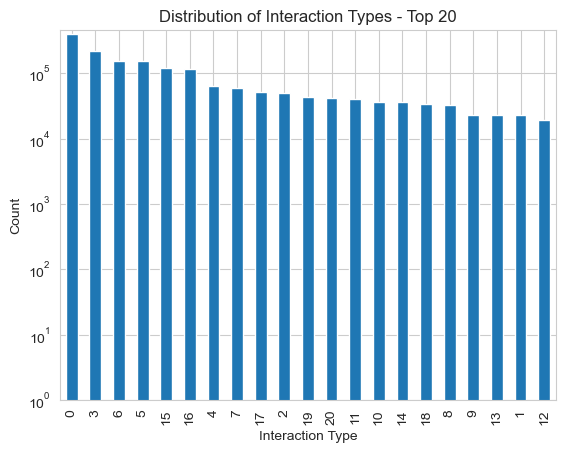

In [10]:
top_20_df['interaction_type'].value_counts().plot(kind='bar', logy=True)
plt.ylabel('Count')
plt.xlabel('Interaction Type')
plt.title('Distribution of Interaction Types - Top 20')
labels = list(range(0, 21, 1))
plt.xticks(labels)
plt.ylim(bottom=1)
plt.show()

In [64]:
# # EDA1
# # How many records having the top 86 value counts for interaction types
# top_86 = ddis_df['interaction'].value_counts().nlargest(86).index
# top_86_df = ddis_df[ddis_df['interaction'].isin(top_86)]
# top_86_df['interaction_type'] = pd.factorize(top_86_df['interaction'])[0] + 1

# print('Number of records for top 86 interactions:', top_86_df.shape)
# print('Bottom 20 value counts of top 86 interactions:\n',top_86_df['interaction'].value_counts()[-20:])

Number of records for top 86 interactions: (1676286, 8)
Bottom 20 value counts of top 86 interactions:
 The risk or severity of myopathy and weakness can be increased when #Drug1 is combined with #Drug2.             1637
The risk or severity of edema formation can be increased when #Drug1 is combined with #Drug2.                   1592
#Drug1 may increase the sedative activities of #Drug2.                                                          1527
#Drug1 may increase the neuromuscular blocking activities of #Drug2.                                            1507
The risk or severity of electrolyte imbalance can be increased when #Drug1 is combined with #Drug2.             1497
The risk or severity of Thrombosis can be increased when #Drug1 is combined with #Drug2.                        1481
#Drug2 may increase the immunosuppressive activities of #Drug1.                                                 1479
#Drug2 may increase the neuroexcitatory activities of #Drug1.                

C:\Users\ltmai\AppData\Local\Temp\ipykernel_14932\221217641.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_86_df['interaction_type'] = pd.factorize(top_86_df['interaction'])[0] + 1


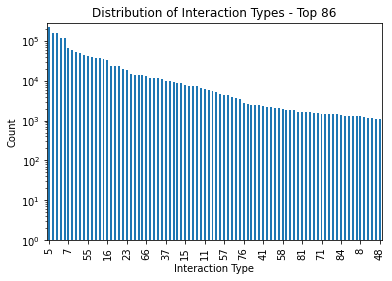

In [65]:
# top_86_df['interaction_type'].value_counts().plot(kind='bar', logy=True)
# plt.ylabel('Count')
# plt.xlabel('Interaction Type')
# plt.title('Distribution of Interaction Types - Top 86')
# labels = list(range(0, 90, 5))
# plt.xticks(labels)
# plt.ylim(bottom=1) 
# plt.show()

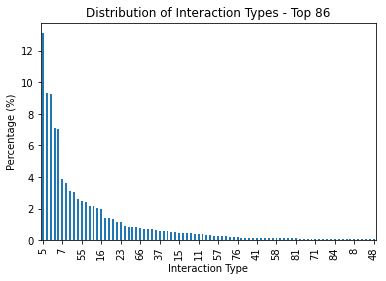

In [66]:
# # calculate the percentage of each value in the column
# percentages = top_86_df['interaction_type'].value_counts(normalize=True) * 100

# # plot the histogram with percentage labels
# percentages.plot(kind='bar')
# plt.ylabel('Percentage (%)')
# plt.xlabel('Interaction Type')
# plt.title('Distribution of Interaction Types - Top 86')
# # plt.xticks(rotation=0)
# # labels = list(range(0, 90, 5))
# plt.xticks(labels)

# # format the y axis labels as percentage
# ax = plt.gca()
# # ax.yaxis.set_major_formatter(PercentFormatter())

# plt.show()

In [37]:
# # EDA2
# # How many records having value counts >1000 for interaction types
# over_1000 = ddis_df['interaction'].value_counts()[ddis_df['interaction'].value_counts() > 1000].index
# over_1000_df = ddis_df[ddis_df['interaction'].isin(over_1000)]
# over_1000_df['interaction_type'] = pd.factorize(over_1000_df['interaction'])[0] + 1
# over_1000_df = over_1000_df[['d1', 'd2', 'd1_name', 'd2_name','rxcui1', 'rxcui2', 'interaction', 'interaction_type']]
# over_1000_df = over_1000_df.astype({'interaction_type': 'int', 'rxcui1': 'int', 'rxcui2':'int'})


# print('Number of records having >1000 interactions:', over_1000_df.shape)
# print('Number of distinct interactions:', len(over_1000_df['interaction'].unique()))
# print('Bottom 20 value counts of having >1000 interactions:\n', over_1000_df['interaction'].value_counts()[-20:])
# over_1000_df.head()

C:\Users\ltmai\AppData\Local\Temp\ipykernel_14932\1703195763.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  over_1000_df['interaction_type'] = pd.factorize(over_1000_df['interaction'])[0] + 1


Number of records having >1000 interactions: (1680420, 8)
Number of distinct interactions: 90
Bottom 20 value counts of having >1000 interactions:
 The risk or severity of electrolyte imbalance can be increased when #Drug1 is combined with #Drug2.             1497
The risk or severity of Thrombosis can be increased when #Drug1 is combined with #Drug2.                        1481
#Drug2 may increase the immunosuppressive activities of #Drug1.                                                 1479
#Drug2 may increase the neuroexcitatory activities of #Drug1.                                                   1466
#Drug1 may increase the neuroexcitatory activities of #Drug2.                                                   1454
#Drug2 may increase the orthostatic hypotensive activities of #Drug1.                                           1401
#Drug1 may increase the immunosuppressive activities of #Drug2.                                                 1322
The risk or severity of angioedem

,d1,d2,d1_name,d2_name,rxcui1,rxcui2,interaction,interaction_type
0,DB00006,DB02709,Bivalirudin,Resveratrol,60819,1000492,The risk or severity of bleeding can be increa...,1
1,DB00006,DB01435,Bivalirudin,Antipyrine,60819,1001,The risk or severity of bleeding and hemorrhag...,2
2,DB00006,DB08867,Bivalirudin,Ulipristal,60819,1005921,The therapeutic efficacy of #Drug1 can be decr...,3
3,DB00006,DB11598,Bivalirudin,Antithrombin III human,60819,221062,The risk or severity of bleeding can be increa...,1
4,DB00006,DB11166,Bivalirudin,Antithrombin Alfa,60819,1427179,The risk or severity of bleeding can be increa...,1


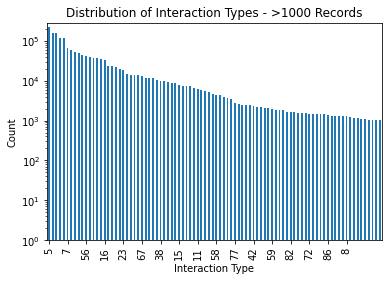

In [38]:
# over_1000_df['interaction_type'].value_counts().plot(kind='bar', logy=True)
# plt.ylabel('Count')
# plt.xlabel('Interaction Type')
# plt.title('Distribution of Interaction Types - >1000 Records')
# labels = list(range(0, 85, 5))
# plt.xticks(labels)
# plt.ylim(bottom=1) 
# plt.show()

In [40]:
# # Merge with interaction type to only focus on the 86 different interaction types
# ddis_df_inter = pd.merge(ddis_df, raw_interactions, on='interaction', how='left')
# ddis_df_inter = ddis_df_inter[['d1', 'd2', 'd1_name', 'd2_name','rxcui1', 'rxcui2', 'interaction', 'interaction_type']]

# # Exclude on NULL interaction_type values
# ddis_df_inter = ddis_df_inter[~ddis_df_inter['interaction_type'].isnull()]
# ddis_df_inter = ddis_df_inter.astype({'interaction_type': 'int'})

# print('The number of records with the chosen 86 interaction_types:', ddis_df_inter.shape[0])
# print('Number of distinct drugs in d1:', len(ddis_df_inter['d1'].unique()))
# print('Number of distinct drugs in d2:', len(ddis_df_inter['d2'].unique()))
# print('Number of distinct interactions:', len(ddis_df_inter['interaction'].unique()))
# print('Value counts of interaction:\n', ddis_df['interaction'].value_counts()[:86])

The number of records with the chosen 86 interaction_types: 947012
Number of distinct drugs in d1: 2637
Number of distinct drugs in d2: 2740
Number of distinct interactions: 74
Value counts of interaction:
 The risk or severity of adverse effects can be increased when #Drug1 is combined with #Drug2.                   220225
#Drug1 may decrease the excretion rate of #Drug2 which could result in a higher serum level.                    156653
#Drug2 may decrease the excretion rate of #Drug1 which could result in a higher serum level.                    154949
The metabolism of #Drug1 can be decreased when combined with #Drug2.                                            119390
The metabolism of #Drug2 can be decreased when combined with #Drug1.                                            118051
                                                                                                                 ...  
The risk or severity of Cardiac Arrhythmia can be increased when #Drug1 is comb

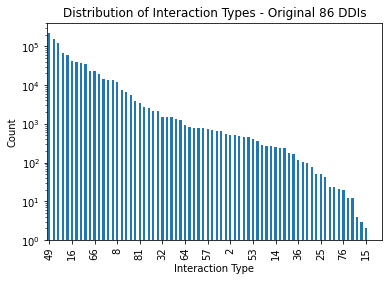

In [41]:
# ddis_df_inter['interaction_type'].value_counts().plot(kind='bar', logy=True)
# plt.ylabel('Count')
# plt.xlabel('Interaction Type')
# plt.title('Distribution of Interaction Types - Original 86 DDIs')
# labels = list(range(0, 75, 5))
# plt.xticks(labels)
# plt.ylim(bottom=1) 
# plt.show()

## Extract DDI from API for ONCHigh

In [46]:
# Test scraping function
drugbank_id = 'DB00338'
# drugbank_id = 'DB00251'
processed_rxcuis = []
test_ddi = get_drugbank_interaction(drugbank_id, verbose=True, sources='ONCHigh')

Extracting interaction for rxnormId 7646
Atazanavir - proton pump inhibitors (PPIs)
('7646', '343047', 'omeprazole', 'atazanavir', 'high', 'Atazanavir - proton pump inhibitors (PPIs)')
Total interactions found for rxnormId 7646: 1


In [47]:
# Scraping all interaction pairs for DrugBank
processed_rxcuis = []
ddis = []
ddis = get_all_interactions(drugbank_ids, sources='ONCHigh')

Scraping 0 to 50 Drug Ids...
Scraping 50 to 100 Drug Ids...
Could not found rxnormId: DB00212
Scraping 100 to 150 Drug Ids...
Could not found rxnormId: DB00267
Scraping 150 to 200 Drug Ids...
Scraping 200 to 250 Drug Ids...
Scraping 250 to 300 Drug Ids...
Could not found rxnormId: DB00430
Scraping 300 to 350 Drug Ids...
Could not found rxnormId: DB00453
Scraping 350 to 400 Drug Ids...
Could not found rxnormId: DB00546
Scraping 400 to 450 Drug Ids...
Could not found rxnormId: DB00614
Scraping 450 to 500 Drug Ids...
Scraping 500 to 550 Drug Ids...
Could not found rxnormId: DB00689
Scraping 550 to 600 Drug Ids...
Could not found rxnormId: DB00764
Could not found rxnormId: DB00769
Scraping 600 to 650 Drug Ids...
Scraping 650 to 700 Drug Ids...
Could not found rxnormId: DB00837
Scraping 700 to 750 Drug Ids...
Scraping 750 to 800 Drug Ids...
Could not found rxnormId: DB00954
Scraping 800 to 850 Drug Ids...
Could not found rxnormId: DB01034
Scraping 850 to 900 Drug Ids...
Could not found rxno

In [69]:
ddis_onch_df = pd.DataFrame(ddis, columns=['rxcui1', 'rxcui2', 'd1_name', 'd2_name','severity', 'interaction'])
# ddis_onch_df = pd.read_csv('data/ddis_from_api_ONCHigh.csv')
ddis_onch_df = ddis_onch_df.drop_duplicates()
ddis_onch_df = ddis_onch_df.astype({'rxcui1': 'int', 'rxcui2':'int', 'd1_name':'str', 'd2_name':'str', 'severity':'str', 'interaction':'str'})
ddis_onch_df.head()

,rxcui1,rxcui2,d1_name,d2_name,severity,interaction
0,42355,10734,fluvoxamine,tranylcypromine,high,Selective serotonin reuptake inhibitors (SSRIs...
1,42355,57258,fluvoxamine,tizanidine,high,Tizanidine - CYP 1A2 inhibitors
2,42355,596205,fluvoxamine,ramelteon,high,Ramelteon - specific CYP1A2 inhibitors
3,42355,6011,fluvoxamine,isocarboxazid,high,Selective serotonin reuptake inhibitors (SSRIs...
4,42355,8123,fluvoxamine,phenelzine,high,Selective serotonin reuptake inhibitors (SSRIs...


In [139]:
print(ddis_onch_df.dtypes)
ddis_onch_df.shape

rxcui1          int32
rxcui2          int32
d1_name        object
d2_name        object
severity       object
interaction    object
dtype: object


(4182, 6)

In [11]:
# Save data
# ddis_onch_df.to_csv("data/ddis_from_api_ONCHigh.csv", index=False)
ddis_onch_df = pd.read_csv("data/ddis_from_api_ONCHigh.csv")

## Merge DrugBank & ONCHigh

In [13]:
##### Merge DrugBank & ONCHigh data
merged_ddis = pd.merge(ddis_df, ddis_onch_df, on= ['rxcui1', 'rxcui2'], how='left')
merged_ddis = merged_ddis.rename(columns={'d1_name_x': 'd1_name', 'd2_name_x':'d2_name', 'interaction_x':'interaction'})

# merged with smiles data
merged_ddis = pd.merge(merged_ddis, raw_smiles, left_on='d1', right_on='drug_id', how='left')
merged_ddis = merged_ddis.rename(columns={"SMILES": "smiles1"})
merged_ddis = pd.merge(merged_ddis, raw_smiles, left_on='d2', right_on='drug_id', how='left')
merged_ddis = merged_ddis.rename(columns={"SMILES": "smiles2"})

# Drop drugs that doesn't have SMILES
merged_ddis = merged_ddis.dropna(subset=['smiles1', 'smiles2'], how='any')

# Drop Dupplicate
merged_ddis = merged_ddis[['d1', 'd2', 'd1_name', 'd2_name', 'interaction', 'severity','smiles1', 'smiles2']]
merged_ddis['interaction_type'] = pd.factorize(merged_ddis['interaction'])[0] + 1
merged_ddis = merged_ddis.drop_duplicates()

# # Check for duplicates pairs
# merged_ddis['d1_d2'] = merged_ddis.apply(lambda x: str([x['d1'], x['d2']]), axis=1)
# print('Merged data dimension:', merged_ddis.shape)
# print('Number of distinct d1-d2 sequence:', len(merged_ddis['d1_d2'].unique()))

# count_pair = dict(merged_ddis.d1_d2.value_counts())

# # Display drug-pairs that have more than 1 interaction in the dataset
# merged_ddis['count_pair'] = merged_ddis.d1_d2.map(count_pair)
# pair_1count = len(merged_ddis[merged_ddis.count_pair == 1]['d1_d2'].unique())
# pair_2count = len(merged_ddis[merged_ddis.count_pair > 1]['d1_d2'].unique())
# print('Number of drug-pairs have 1 interaction:', pair_1count)
# print('Number of drug-pairs have >1 interactions:', pair_2count)

# merged_ddis[merged_ddis.count_pair > 1].sort_values('d1_d2').head(10)


In [14]:
# Check high severity for Omeprazole 
merged_ddis[merged_ddis['severity'] == 'high'][merged_ddis['d1_name'] == 'Omeprazole'].head()

C:\Users\ltmai\AppData\Local\Temp\ipykernel_39200\887689913.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  merged_ddis[merged_ddis['severity'] == 'high'][merged_ddis['d1_name'] == 'Omeprazole'].head()


,d1,d2,d1_name,d2_name,interaction,severity,smiles1,smiles2,interaction_type
194120,DB00338,DB01072,Omeprazole,Atazanavir,#Drug1 can cause a decrease in the absorption of #Drug2 resulting in a reduced serum concentrati...,high,COC1=CC2=C(C=C1)N=C(N2)S(=O)CC1=NC=C(C)C(OC)=C1C,COC(=O)N[C@H](C(=O)N[C@@H](CC1=CC=CC=C1)[C@@H](O)CN(CC1=CC=C(C=C1)C1=CC=CC=N1)NC(=O)[C@@H](NC(=O...,107


In [9]:
# EDA
print('Merged data dimension:', merged_ddis.shape)
print('Number of distinct drugs in d1:', len(merged_ddis['d1'].unique()))
print('Number of distinct drugs in d2:', len(merged_ddis['d2'].unique()))
print('Number of distinct interaction:', len(merged_ddis['interaction'].unique()))
print('Number of missing values:\n', merged_ddis.isnull().sum())
print('Number of classifications:\n', merged_ddis['interaction'].value_counts())

Merged data dimension: (1405350, 8)
Number of distinct drugs in d1: 2415
Number of distinct drugs in d2: 2448
Number of distinct interaction: 739
Number of missing values:
 d1                   0
d2                   0
d1_name              0
d2_name              0
interaction          0
severity       1401673
smiles1              0
smiles2              0
dtype: int64
Number of classifications:
 The risk or severity of adverse effects can be increased when #Drug1 is combined with #Drug2.                                                               180529
#Drug2 may decrease the excretion rate of #Drug1 which could result in a higher serum level.                                                                122789
#Drug1 may decrease the excretion rate of #Drug2 which could result in a higher serum level.                                                                116559
The metabolism of #Drug2 can be decreased when combined with #Drug1.                                             

In [14]:
##### Merge Top20 DrugBank & ONCHigh data
merged_ddis20 = pd.merge(top_20_df, ddis_onch_df, on= ['rxcui1', 'rxcui2'], how='left')
merged_ddis20 = merged_ddis20.rename(columns={'d1_name_x': 'd1_name', 'd2_name_x':'d2_name', 'interaction_x':'interaction'})

# merged with smiles data
merged_ddis20 = pd.merge(merged_ddis20, raw_smiles, left_on='d1', right_on='drug_id', how='left')
merged_ddis20 = merged_ddis20.rename(columns={"SMILES": "smiles1"})
merged_ddis20 = pd.merge(merged_ddis20, raw_smiles, left_on='d2', right_on='drug_id', how='left')
merged_ddis20 = merged_ddis20.rename(columns={"SMILES": "smiles2"})

# Drop drugs that doesn't have SMILES
merged_ddis20 = merged_ddis20.dropna(subset=['smiles1', 'smiles2'], how='any')

# Drop Dupplicate
merged_ddis20 = merged_ddis20[['d1', 'd2', 'd1_name', 'd2_name', 'interaction', 'interaction_type', 'severity','smiles1', 'smiles2']]
# merged_ddis20['interaction_type'] = pd.factorize(merged_ddis20['interaction'])[0] + 1
merged_ddis20 = merged_ddis20.drop_duplicates()
merged_ddis20.head(25)

,d1,d2,d1_name,d2_name,interaction,interaction_type,severity,smiles1,smiles2
145,DB00006,DB00752,Bivalirudin,Tranylcypromine,The risk or severity of bleeding and hemorrhage can be increased when #Drug1 is combined with #D...,0,NaN,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@H](C...,NC1CC1C1=CC=CC=C1
146,DB00006,DB06228,Bivalirudin,Rivaroxaban,#Drug1 may increase the anticoagulant activities of #Drug2.,0,NaN,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@H](C...,ClC1=CC=C(S1)C(=O)NC[C@H]1CN(C(=O)O1)C1=CC=C(C=C1)N1CCOCC1=O
147,DB00006,DB13946,Bivalirudin,Testosterone undecanoate,#Drug2 may increase the anticoagulant activities of #Drug1.,0,NaN,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@H](C...,CCCCCCCCCCC(=O)O[C@H]1CC[C@H]2[C@@H]3CCC4=CC(=O)CC[C@]4(C)[C@H]3CC[C@]12C
148,DB00006,DB00605,Bivalirudin,Sulindac,The risk or severity of bleeding and hemorrhage can be increased when #Drug1 is combined with #D...,0,NaN,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@H](C...,CC1=C(CC(O)=O)C2=CC(F)=CC=C2\C1=C/C1=CC=C(C=C1)S(C)=O
149,DB00006,DB06695,Bivalirudin,Dabigatran etexilate,#Drug2 may increase the anticoagulant activities of #Drug1.,0,NaN,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@H](C...,CCCCCCOC(=O)\N=C(\N)C1=CC=C(NCC2=NC3=C(C=CC(=C3)C(=O)N(CCC(=O)OCC)C3=NC=CC=C3)N2C)C=C1
150,DB00006,DB00624,Bivalirudin,Testosterone,#Drug2 may increase the anticoagulant activities of #Drug1.,0,NaN,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@H](C...,[H][C@@]12CC[C@H](O)[C@@]1(C)CC[C@@]1([H])[C@@]2([H])CCC2=CC(=O)CC[C@]12C
151,DB00006,DB01420,Bivalirudin,Testosterone propionate,#Drug2 may increase the anticoagulant activities of #Drug1.,0,NaN,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@H](C...,[H][C@@]12CC[C@H](OC(=O)CC)[C@@]1(C)CC[C@@]1([H])[C@@]2([H])CCC2=CC(=O)CC[C@]12C
152,DB00006,DB01435,Bivalirudin,Antipyrine,The risk or severity of bleeding and hemorrhage can be increased when #Drug1 is combined with #D...,0,NaN,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@H](C...,CN1N(C(=O)C=C1C)C1=CC=CC=C1
153,DB00006,DB13944,Bivalirudin,Testosterone enanthate,#Drug2 may increase the anticoagulant activities of #Drug1.,0,NaN,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@H](C...,[H][C@@]12CC[C@H](OC(=O)CCCCCC)[C@@]1(C)CC[C@@]1([H])[C@@]2([H])CCC2=CC(=O)CC[C@]12C
154,DB00006,DB00500,Bivalirudin,Tolmetin,The risk or severity of bleeding and hemorrhage can be increased when #Drug1 is combined with #D...,0,NaN,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@H](C...,CN1C(CC(O)=O)=CC=C1C(=O)C1=CC=C(C)C=C1


In [15]:
merged_ddis20['interaction_type'].value_counts()

0     302945
3     180529
5     122789
6     116559
16    106837
15    105953
7      55391
2      40991
4      40216
19     39624
20     38169
11     36974
14     32036
10     31871
17     30143
18     29666
8      26820
9      19267
13     17795
12     17252
1      13523
Name: interaction_type, dtype: int64

In [16]:
# Save data
merged_ddis20.to_csv("data/top20_ddi/ddis_from_api_top20.csv", index=False, sep='\t')

In [158]:
# ## Subset data to only include the top 86 interaction types
# # How many records having the top 86 value counts for interaction types
# top_86 = merged_ddis['interaction'].value_counts().nlargest(86).index
# top_86_df = merged_ddis[merged_ddis['interaction'].isin(top_86)]
# top_86_df = top_86_df.drop_duplicates()
# top_86_df['interaction_type'] = pd.factorize(top_86_df['interaction'])[0] + 1
#
# print('Number of records for top 86 interactions:', top_86_df.shape)
# print('Bottom 20 value counts of top 86 interactions:\n',top_86_df['interaction'].value_counts())
# top_86_df.head(2)

Number of records for top 86 interactions: (1357381, 9)
Bottom 20 value counts of top 86 interactions:
 The risk or severity of adverse effects can be increased when #Drug1 is combined with #Drug2.                                                         180529
#Drug2 may decrease the excretion rate of #Drug1 which could result in a higher serum level.                                                          122789
#Drug1 may decrease the excretion rate of #Drug2 which could result in a higher serum level.                                                          116559
The metabolism of #Drug2 can be decreased when combined with #Drug1.                                                                                  106837
The metabolism of #Drug1 can be decreased when combined with #Drug2.                                                                                  105953
                                                                                                               

,d1,d2,d1_name,d2_name,interaction,severity,smiles1,smiles2,interaction_type
0,DB00006,DB02709,Bivalirudin,Resveratrol,The risk or severity of bleeding can be increased when #Drug1 is combined with #Drug2.,NaN,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@H](C...,OC1=CC=C(\C=C\C2=CC(O)=CC(O)=C2)C=C1,1
1,DB00006,DB01435,Bivalirudin,Antipyrine,The risk or severity of bleeding and hemorrhage can be increased when #Drug1 is combined with #D...,NaN,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CCC(O)=O)NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)[C@H](C...,CN1N(C(=O)C=C1C)C1=CC=CC=C1,2


In [159]:
# print('Number of drug1 without SMILES:', len(top_86_df[top_86_df['smiles1'].isnull()]['d1'].unique()))
# print(top_86_df[top_86_df['smiles1'].isnull()]['d1'].unique())
# print('Number of drug2 without SMILES:', len(top_86_df[top_86_df['smiles2'].isnull()]['d2'].unique()))
# print(top_86_df[top_86_df['smiles2'].isnull()]['d2'].unique())

Number of drug1 without SMILES: 0
[]
Number of drug2 without SMILES: 0
[]


In [160]:
# # EDA
# # Interactions has "HIGH" severity
# high_severity_df = top_86_df[top_86_df['severity'] == 'high']
# print('The number of records with high severity:', high_severity_df.shape[0])
# print('Number of distinct drugs in d1:', len(high_severity_df['d1'].unique()))
# print('Number of distinct drugs in d2:', len(high_severity_df['d2'].unique()))
# print('Number of distinct interactions:', len(high_severity_df['interaction'].unique()))
# print('Value counts interactions:')
# print(high_severity_df['interaction'].value_counts())

The number of records with high severity: 3242
Number of distinct drugs in d1: 129
Number of distinct drugs in d2: 129
Number of distinct interactions: 31
Value counts interactions:
The risk or severity of QTc prolongation can be increased when #Drug1 is combined with #Drug2.                                                1702
The metabolism of #Drug2 can be decreased when combined with #Drug1.                                                                           355
The metabolism of #Drug1 can be decreased when combined with #Drug2.                                                                           352
The risk or severity of adverse effects can be increased when #Drug1 is combined with #Drug2.                                                  157
The serum concentration of #Drug1 can be increased when it is combined with #Drug2.                                                             97
The serum concentration of #Drug2 can be increased when it is combined with #Drug1.

In [11]:
# EDA2
# Merge with interaction type to only focus on the original 86 different interaction types
raw_interactions = pd.read_csv('data/archive/Interaction_information.csv')
raw_interactions = raw_interactions.rename(columns={"Interaction type": "interaction_type", "Description":"interaction"})
raw_interactions = raw_interactions[["interaction_type", "interaction"]]
raw_interactions.head()

,interaction_type,interaction
0,67,#Drug1 can cause a decrease in the absorption of #Drug2 resulting in a reduced serum concentrati...
1,18,#Drug1 can cause an increase in the absorption of #Drug2 resulting in an increased serum concent...
2,45,#Drug1 may decrease effectiveness of #Drug2 as a diagnostic agent.
3,52,#Drug1 may decrease the analgesic activities of #Drug2.
4,12,#Drug1 may decrease the anticoagulant activities of #Drug2.


In [128]:
# EDA2
# # Merge with interaction type to only focus on the 86 different interaction types
# ddis_df_inter = pd.merge(merged_ddis, raw_interactions, on='interaction', how='left')
# ddis_df_inter = ddis_df_inter[['d1', 'd2', 'd1_name', 'd2_name', 'interaction', 'severity','smiles1', 'smiles2', 'interaction_type']]

# # Exclude on NULL interaction_type values
# ddis_df_inter = ddis_df_inter[~ddis_df_inter['interaction_type'].isnull()]
# ddis_df_inter = ddis_df_inter.astype({'interaction_type': 'int'})

# print('The number of records with the chosen 86 interaction_types:', ddis_df_inter.shape[0])
# print('Number of distinct drugs in d1:', len(ddis_df_inter['d1'].unique()))
# print('Number of distinct drugs in d2:', len(ddis_df_inter['d2'].unique()))
# print('Number of distinct interactions:', len(ddis_df_inter['interaction'].unique()))
# print('Value counts of Bottom interaction:\n', ddis_df_inter['interaction'].value_counts())

The number of records with the chosen 86 interaction_types: 767660
Number of distinct drugs in d1: 2316
Number of distinct drugs in d2: 2295
Number of distinct interactions: 74
Value counts of Bottom interaction:
 The risk or severity of adverse effects can be increased when #Drug1 is combined with #Drug2.     180529
#Drug1 may decrease the excretion rate of #Drug2 which could result in a higher serum level.      116559
The metabolism of #Drug2 can be decreased when combined with #Drug1.                              106837
The risk or severity of QTc prolongation can be increased when #Drug1 is combined with #Drug2.     55391
The therapeutic efficacy of #Drug2 can be decreased when used in combination with #Drug1.          40216
                                                                                                   ...  
#Drug1 may decrease the antiplatelet activities of #Drug2.                                             3
#Drug1 may increase the dermatologic adverse activi

In [15]:
## Adjust Severity with ONCHigh Data
# Choose only DDI in the format of "Drug1 cause something to Drug2" using the firt raw DDI data
original_severity = raw_interactions['interaction'].values
drug2_high_severity = merged_ddis[merged_ddis['severity'] == 'high'][merged_ddis['interaction'].isin(original_severity)]
drug2_high_severity["d2_ddi_type"] = drug2_high_severity.apply(lambda x: str([x['d2'], x['interaction_type']]), axis=1)
drug2_high_severity = drug2_high_severity["d2_ddi_type"].unique()
print('The number of Drug2 & High severity combination:', len(drug2_high_severity))
print('Example of Drug2 - High severity:', drug2_high_severity[:2])

adjusted_high_df = merged_ddis.copy()
adjusted_high_df["d2_ddi_type"] = adjusted_high_df.apply(lambda x: str([x['d2'], x['interaction_type']]), axis=1)
adjusted_high_df["d1_d2"] = adjusted_high_df.apply(lambda x: str([x['d1'], x['d2']]), axis=1)

# Update Severity to High if Drug2 are found in the high severity group of other drugs
adjusted_high_df['severity'] = np.where(adjusted_high_df['d2_ddi_type'].isin(drug2_high_severity)
                                        | adjusted_high_df['severity'].isin(['high']), 'high', 'unknown')
adjusted_high_df['severity'] = np.where(adjusted_high_df['interaction'].str.contains('The risk or severity of'),'high', adjusted_high_df['severity'])

# Drug1-Drug2 pair with high severity
pair_high_severity = adjusted_high_df[adjusted_high_df['severity'] == 'high']
pair_high_severity["d1_d2"] = pair_high_severity.apply(lambda x: str([x['d1'], x['d2']]), axis=1)
pair_high_severity = pair_high_severity["d1_d2"].unique()
print('The number of Drug1 & Drug2 with High severity:', len(pair_high_severity))
print('Example of Drug1 - Drug2 with High severity:', pair_high_severity[:2])

# Update Severity to High for Drug1 - Drug 2 pair found in high severity group
adjusted_high_df['severity'] = np.where(adjusted_high_df['d1_d2'].isin(pair_high_severity), 'high',
                                        adjusted_high_df['severity'])

adjusted_high_df = adjusted_high_df.drop(["d2_ddi_type", "d1_d2"], axis=1)
adjusted_high_df = adjusted_high_df.dropna(subset=['smiles1', 'smiles2'], how='any')
adjusted_high_df = adjusted_high_df.drop_duplicates()

print('The number of records with adjusted high severity:', adjusted_high_df.shape[0])
print('The number of records with high severity:', adjusted_high_df[adjusted_high_df['severity'] == 'high'].shape[0])
print('Value counts of severity:')
print(adjusted_high_df['severity'].value_counts())
adjusted_high_df[adjusted_high_df["d1_name"] == "Omeprazole"][adjusted_high_df["severity"] == "high"].head()

C:\Users\ltmai\AppData\Local\Temp\ipykernel_39200\2294904330.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  drug2_high_severity = merged_ddis[merged_ddis['severity'] == 'high'][merged_ddis['interaction'].isin(original_severity)]


The number of Drug2 & High severity combination: 270
Example of Drug2 - High severity: ["['DB00697', 42]" "['DB00980', 21]"]


C:\Users\ltmai\AppData\Local\Temp\ipykernel_39200\2294904330.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pair_high_severity["d1_d2"] = pair_high_severity.apply(lambda x: str([x['d1'], x['d2']]), axis=1)


The number of Drug1 & Drug2 with High severity: 445095
Example of Drug1 - Drug2 with High severity: ["['DB00006', 'DB02709']" "['DB00006', 'DB01435']"]
The number of records with adjusted high severity: 1405083
The number of records with high severity: 446915
Value counts of severity:
unknown    958168
high       446915
Name: severity, dtype: int64


C:\Users\ltmai\AppData\Local\Temp\ipykernel_39200\2294904330.py:38: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  adjusted_high_df[adjusted_high_df["d1_name"] == "Omeprazole"][adjusted_high_df["severity"] == "high"].head()


,d1,d2,d1_name,d2_name,interaction,severity,smiles1,smiles2,interaction_type
193635,DB00338,DB00679,Omeprazole,Thioridazine,The metabolism of #Drug2 can be decreased when combined with #Drug1.,high,COC1=CC2=C(C=C1)N=C(N2)S(=O)CC1=NC=C(C)C(OC)=C1C,CSC1=CC2=C(SC3=CC=CC=C3N2CCC2CCCCN2C)C=C1,53
193659,DB00338,DB05294,Omeprazole,Vandetanib,The metabolism of #Drug2 can be increased when combined with #Drug1.,high,COC1=CC2=C(C=C1)N=C(N2)S(=O)CC1=NC=C(C)C(OC)=C1C,COC1=C(OCC2CCN(C)CC2)C=C2N=CN=C(NC3=C(F)C=C(Br)C=C3)C2=C1,69
193709,DB00338,DB00220,Omeprazole,Nelfinavir,The serum concentration of #Drug2 can be decreased when it is combined with #Drug1.,high,COC1=CC2=C(C=C1)N=C(N2)S(=O)CC1=NC=C(C)C(OC)=C1C,[H][C@@]12CCCC[C@]1([H])CN(C[C@@H](O)[C@H](CSC1=CC=CC=C1)NC(=O)C1=C(C)C(O)=CC=C1)[C@@H](C2)C(=O)...,46
193712,DB00338,DB00843,Omeprazole,Donepezil,#Drug1 may decrease the excretion rate of #Drug2 which could result in a higher serum level.,high,COC1=CC2=C(C=C1)N=C(N2)S(=O)CC1=NC=C(C)C(OC)=C1C,COC1=C(OC)C=C2C(=O)C(CC3CCN(CC4=CC=CC=C4)CC3)CC2=C1,14
193740,DB00338,DB01244,Omeprazole,Bepridil,The metabolism of #Drug2 can be decreased when combined with #Drug1.,high,COC1=CC2=C(C=C1)N=C(N2)S(=O)CC1=NC=C(C)C(OC)=C1C,CC(C)COCC(CN(CC1=CC=CC=C1)C1=CC=CC=C1)N1CCCC1,53


In [162]:
# ## Adjust Severity with ONCHigh Data
# # Choose only DDI in the format of "Drug1 cause something to Drug2" using the firt raw DDI data
# original_severity = raw_interactions['interaction'].values
# drug2_high_severity = top_86_df[top_86_df['severity'] == 'high'][top_86_df['interaction'].isin(original_severity)]
# drug2_high_severity["d2_ddi_type"] = drug2_high_severity.apply(lambda x: str([x['d2'], x['interaction_type']]), axis=1)
# drug2_high_severity = drug2_high_severity["d2_ddi_type"].unique()
# print('The number of Drug2 & High severity combination:', len(drug2_high_severity))
# print('Example of Drug2 - High severity:', drug2_high_severity[:2])
#
# adjusted_high_df = top_86_df.copy()
# adjusted_high_df["d2_ddi_type"] = adjusted_high_df.apply(lambda x: str([x['d2'], x['interaction_type']]), axis=1)
# adjusted_high_df["d1_d2"] = adjusted_high_df.apply(lambda x: str([x['d1'], x['d2']]), axis=1)
#
# # Update Severity to High if Drug2 are found in the high severity group of other drugs
# adjusted_high_df['severity'] = np.where(adjusted_high_df['d2_ddi_type'].isin(drug2_high_severity)
#                                         | adjusted_high_df['severity'].isin(['high']), 'high', 'unknown')
# adjusted_high_df['severity'] = np.where(adjusted_high_df['interaction'].str.contains('The risk or severity of'),'high', adjusted_high_df['severity'])
#
# # Drug1-Drug2 pair with high severity
# pair_high_severity = adjusted_high_df[adjusted_high_df['severity'] == 'high']
# pair_high_severity["d1_d2"] = pair_high_severity.apply(lambda x: str([x['d1'], x['d2']]), axis=1)
# pair_high_severity = pair_high_severity["d1_d2"].unique()
# print('The number of Drug1 & Drug2 with High severity:', len(pair_high_severity))
# print('Example of Drug1 - Drug2 with High severity:', pair_high_severity[:2])
#
# # Update Severity to High for Drug1 - Drug 2 pair found in high severity group
# adjusted_high_df['severity'] = np.where(adjusted_high_df['d1_d2'].isin(pair_high_severity), 'high',
#                                         adjusted_high_df['severity'])
#
# adjusted_high_df = adjusted_high_df.drop(["d2_ddi_type", "d1_d2"], axis=1)
# adjusted_high_df = adjusted_high_df.dropna(subset=['smiles1', 'smiles2'], how='any')
# adjusted_high_df = adjusted_high_df.drop_duplicates()
#
# print('The number of records with adjusted high severity:', adjusted_high_df.shape[0])
# print('The number of records with high severity:', adjusted_high_df[adjusted_high_df['severity'] == 'high'].shape[0])
# print('Value counts of severity:')
# print(adjusted_high_df['severity'].value_counts())
# adjusted_high_df[adjusted_high_df["d1_name"] == "Omeprazole"][adjusted_high_df["severity"] == "high"].head()

C:\Users\ltmai\AppData\Local\Temp\ipykernel_14932\2988799000.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  drug2_high_severity = top_86_df[top_86_df['severity'] == 'high'][top_86_df['interaction'].isin(original_severity)]


The number of Drug2 & High severity combination: 237
Example of Drug2 - High severity: ["['DB00697', 23]" "['DB00980', 16]"]


C:\Users\ltmai\AppData\Local\Temp\ipykernel_14932\2988799000.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pair_high_severity["d1_d2"] = pair_high_severity.apply(lambda x: str([x['d1'], x['d2']]), axis=1)


The number of Drug1 & Drug2 with High severity: 428475
Example of Drug1 - Drug2 with High severity: ["['DB00006', 'DB02709']" "['DB00006', 'DB01435']"]
The number of records with adjusted high severity: 1357134
The number of records with high severity: 428475
Value counts of severity:
unknown    928659
high       428475
Name: severity, dtype: int64


C:\Users\ltmai\AppData\Local\Temp\ipykernel_14932\2988799000.py:38: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  adjusted_high_df[adjusted_high_df["d1_name"] == "Omeprazole"][adjusted_high_df["severity"] == "high"].head()


,d1,d2,d1_name,d2_name,interaction,severity,smiles1,smiles2,interaction_type
193635,DB00338,DB00679,Omeprazole,Thioridazine,The metabolism of #Drug2 can be decreased when combined with #Drug1.,high,COC1=CC2=C(C=C1)N=C(N2)S(=O)CC1=NC=C(C)C(OC)=C1C,CSC1=CC2=C(SC3=CC=CC=C3N2CCC2CCCCN2C)C=C1,29
193659,DB00338,DB05294,Omeprazole,Vandetanib,The metabolism of #Drug2 can be increased when combined with #Drug1.,high,COC1=CC2=C(C=C1)N=C(N2)S(=O)CC1=NC=C(C)C(OC)=C1C,COC1=C(OCC2CCN(C)CC2)C=C2N=CN=C(NC3=C(F)C=C(Br)C=C3)C2=C1,40
193709,DB00338,DB00220,Omeprazole,Nelfinavir,The serum concentration of #Drug2 can be decreased when it is combined with #Drug1.,high,COC1=CC2=C(C=C1)N=C(N2)S(=O)CC1=NC=C(C)C(OC)=C1C,[H][C@@]12CCCC[C@]1([H])CN(C[C@@H](O)[C@H](CSC1=CC=CC=C1)NC(=O)C1=C(C)C(O)=CC=C1)[C@@H](C2)C(=O)...,25
193712,DB00338,DB00843,Omeprazole,Donepezil,#Drug1 may decrease the excretion rate of #Drug2 which could result in a higher serum level.,high,COC1=CC2=C(C=C1)N=C(N2)S(=O)CC1=NC=C(C)C(OC)=C1C,COC1=C(OC)C=C2C(=O)C(CC3CCN(CC4=CC=CC=C4)CC3)CC2=C1,11
193740,DB00338,DB01244,Omeprazole,Bepridil,The metabolism of #Drug2 can be decreased when combined with #Drug1.,high,COC1=CC2=C(C=C1)N=C(N2)S(=O)CC1=NC=C(C)C(OC)=C1C,CC(C)COCC(CN(CC1=CC=CC=C1)C1=CC=CC=C1)N1CCCC1,29


In [16]:
print('Number of missing values:\n', adjusted_high_df.isnull().sum())
print(adjusted_high_df['interaction_type'].value_counts())

Number of missing values:
 d1                  0
d2                  0
d1_name             0
d2_name             0
interaction         0
severity            0
smiles1             0
smiles2             0
interaction_type    0
dtype: int64
6      180527
13     122789
14     116559
53     106829
50     105945
        ...  
587         1
589         1
590         1
593         1
739         1
Name: interaction_type, Length: 739, dtype: int64


In [17]:
# Save data
adjusted_high_df.to_csv("data/ddis_from_api_full.csv", index=False, sep='\t')
# adjusted_high_df.to_csv("data/ddis_from_api.csv", index=False, sep='\t')
# adjusted_high_df.to_csv("data/ddis_from_api.txt", index=False, sep='\t')